##### Build TUSCAN model

In [1]:
from sklearn.ensemble import RandomForestRegressor
import pybedtools # required for TUSCAN.py

In [2]:
!python3 ModelBuilder.py -r RegressionMatrix.txt RegressionFeatures.txt

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Building Random Forest
Fitting Random Forest Regressor
Built!


##### First, run TUSCAN over each viral segment

In this example, we are comparing H1N1 and H5N1 genomes.

In [3]:
!python3 TUSCAN.py -g H1N1_1.fa -o H1N1_1.out -c 1 -m Regression
!python3 TUSCAN.py -g H1N1_2.fa -o H1N1_2.out -c 2 -m Regression
!python3 TUSCAN.py -g H1N1_3.fa -o H1N1_3.out -c 3 -m Regression
!python3 TUSCAN.py -g H1N1_4.fa -o H1N1_4.out -c 4 -m Regression
!python3 TUSCAN.py -g H1N1_5.fa -o H1N1_5.out -c 5 -m Regression
!python3 TUSCAN.py -g H1N1_6.fa -o H1N1_6.out -c 6 -m Regression
!python3 TUSCAN.py -g H1N1_7.fa -o H1N1_7.out -c 7 -m Regression
!python3 TUSCAN.py -g H1N1_8.fa -o H1N1_8.out -c 8 -m Regression
!python3 TUSCAN.py -g H5N1_1.fa -o H5N1_1.out -c 1 -m Regression
!python3 TUSCAN.py -g H5N1_2.fa -o H5N1_2.out -c 2 -m Regression
!python3 TUSCAN.py -g H5N1_3.fa -o H5N1_3.out -c 3 -m Regression
!python3 TUSCAN.py -g H5N1_4.fa -o H5N1_4.out -c 4 -m Regression
!python3 TUSCAN.py -g H5N1_5.fa -o H5N1_5.out -c 5 -m Regression
!python3 TUSCAN.py -g H5N1_6.fa -o H5N1_6.out -c 6 -m Regression
!python3 TUSCAN.py -g H5N1_7.fa -o H5N1_7.out -c 7 -m Regression
!python3 TUSCAN.py -g H5N1_8.fa -o H5N1_8.out -c 8 -m Regression

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
H1N1_1.out	done
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
H1

##### Next we concatenate all potential targets sites from each segment into one file for each virus. 
In this step we also trim whitespace and tabs

In [4]:
!cat H5N1_*.out | tr -s " \t" "\t" > H5N1_merged.txt
!cat H1N1_*.out | tr -s " \t" "\t" > H1N1_merged.txt

##### The penultimate step is to sort the files based on their targets, to facilitate locating unique targets. 

In [5]:
!sort -k 5 H5N1_merged.txt > H5N1_sorted.txt
!sort -k 5 H1N1_merged.txt > H1N1_sorted.txt

##### Finally, we use join on these merged files and extract only the unique (unpaired joins) targets from each virus 

In [6]:
!join -v 1 -1 5 -2 5 H5N1_sorted.txt H1N1_sorted.txt > H5N1_unique.txt
!join -v 2 -1 5 -2 5 H5N1_sorted.txt H1N1_sorted.txt > H1N1_unique.txt

##### Examine Output:

In [7]:
!echo "CRISPR-Cas9 Targets unique to H5N1 Virus\n"
!echo "Segment\tStart\tEnd\tStrand\tSequence\t\tTUSCAN_Score"
!cat H5N1_unique.txt | tr " " "\t" | sort -V #CRISPR-Cas9 targets unique to H5N1 virus 

CRISPR-Cas9 Targets unique to H5N1 Virus

Segment	Start	End	Strand	Sequence		TUSCAN_Score
1	9	31	+	CAGGTCAAATATATTCAATATGG	1.1618866784222088
1	68	90	-	TGTTAGTATCTCGCGAGTGCGGG	0.3734402883968521
1	69	91	-	TTGTTAGTATCTCGCGAGTGCGG	1.3812848833146867
1	81	103	+	GATACTAACAAAAACCACTGTGG	2.6418196786357098
1	90	112	+	AAAAACCACTGTGGACCATATGG	2.3217411968032007
1	105	127	-	ATTTCTTGATTATGGCCATATGG	0.6141378939471879
1	113	135	-	TGATGTGTATTTCTTGATTATGG	0.12638875293560733
1	115	137	+	ATAATCAAGAAATACACATCAGG	1.1188114523979404
1	152	174	+	ACCCTGCTCTCAGAATGAAATGG	0.7301377924407599
1	153	175	-	TCCATTTCATTCTGAGAGCAGGG	1.0663777591056416
1	154	176	-	ATCCATTTCATTCTGAGAGCAGG	0.2810137665565094
1	159	181	+	TCTCAGAATGAAATGGATGATGG	1.667055596809225
1	183	205	+	AATGAAATATCCAATCACAGCGG	2.7237238195687734
1	193	215	-	ATTCTCTTGTCCGCTGTGATTGG	0.8874783776485697
1	215	237	+	TAATAGAGATGATTCCTGAAAGG	2.044305389338148
1	226	248	+	ATTCCTGAAAGGAATGAACAAGG	1.0830947847957393
1	227	249	+	TTCCTGAAAGGAATGAACAAGGG	1.02

In [8]:
!echo "CRISPR-Cas9 Targets unique to H1N1 Virus\n"
!echo "Segment\tStart\tEnd\tStrand\tSequence\t\tTUSCAN_Score"
!cat H1N1_unique.txt | tr " " "\t" | sort -V #CRISPR-Cas9 targets unique to H1N1 virus 

CRISPR-Cas9 Targets unique to H1N1 Virus

Segment	Start	End	Strand	Sequence		TUSCAN_Score
1	41	63	-	AGTGAGTATCTCGCGAGTGCGGG	0.26531329125579534
1	42	64	-	TAGTGAGTATCTCGCGAGTGCGG	2.5504155960099832
1	54	76	+	GATACTCACTAAGACCACTGTGG	2.857544498251576
1	63	85	+	TAAGACCACTGTGGACCATATGG	1.8333008049309023
1	78	100	-	ACTTTTTGATTATGGCCATATGG	0.917861903571102
1	86	108	-	TGATGTGTACTTTTTGATTATGG	0.07911763996191429
1	88	110	+	ATAATCAAAAAGTACACATCAGG	1.1188114523979404
1	92	114	+	TCAAAAAGTACACATCAGGAAGG	1.7913534389134258
1	125	147	+	ACCCCGCACTCAGAATGAAATGG	1.4490985862493544
1	126	148	-	TCCATTTCATTCTGAGTGCGGGG	3.597815606619376
1	127	149	-	ATCCATTTCATTCTGAGTGCGGG	0.2642407759095401
1	128	150	-	CATCCATTTCATTCTGAGTGCGG	1.2436440728124378
1	132	154	+	ACTCAGAATGAAATGGATGATGG	1.950948805875261
1	165	187	-	TTCTCTTGTCTGCTGTAATTGGG	0.13058411625799185
1	166	188	-	ATTCTCTTGTCTGCTGTAATTGG	0.11058701173472944
1	171	193	+	TACAGCAGACAAGAGAATAATGG	1.8356131471078274
1	188	210	+	TAATGGACATGATTCCAGAGAGG	2.8992

##### Extract Segment 8  from each target list

In [9]:
!cat H1N1_unique.txt | grep ^8 > H1N1_8.txt
!cat H5N1_unique.txt | grep ^8 > H5N1_8.txt

##### Create heatmap showing similarity of targets between H1N1 and H5N1 on segment 8

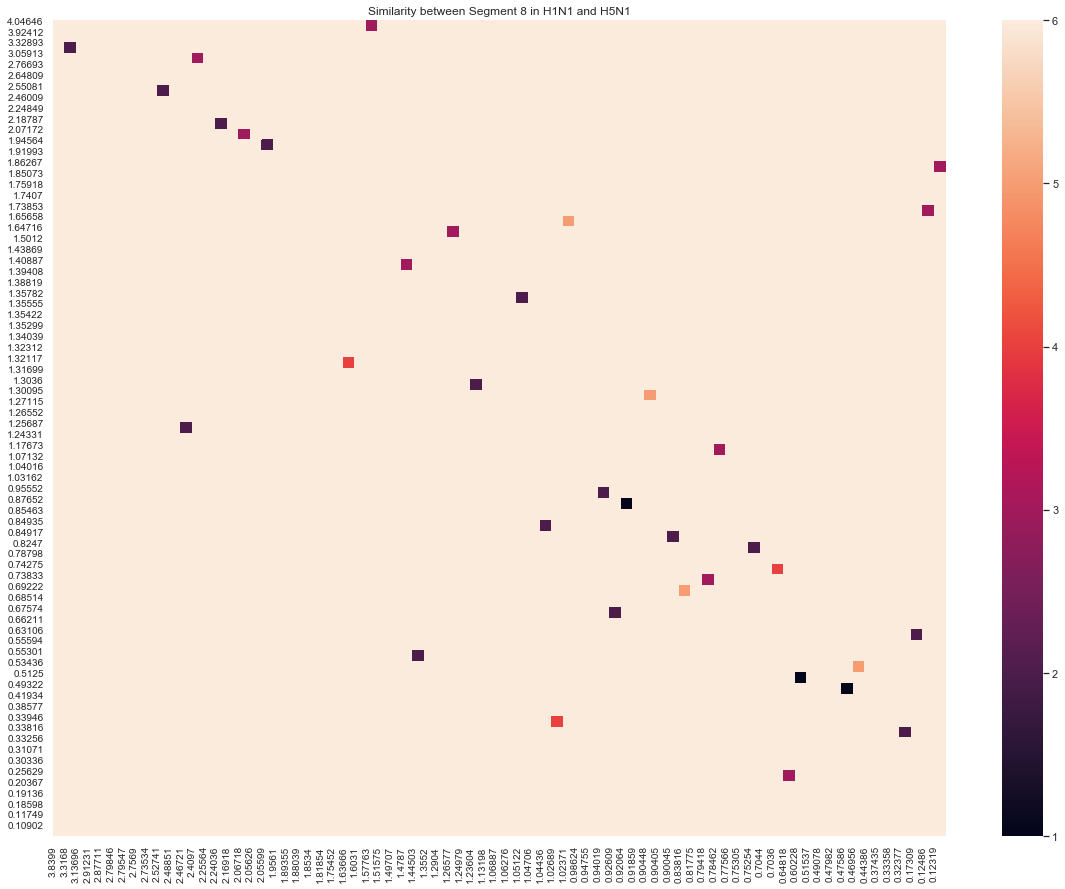

In [11]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()

sample_1 = []
sample_2 = []

with open("H1N1_8.txt", "r") as f:
    for line in f:
        words = line.split()
        seq = words[4]
        score = words[5]
        score = round(float(score), 5)
        sample_1.append((words[0], words[1], words[2], words[3], seq, score))

with open("H5N1_8.txt", "r") as f:
    for line in f:
        words = line.split()
        seq = words[4]
        score = words[5]
        score = round(float(score), 5)
        sample_2.append((words[0], words[1], words[2], words[3], seq, score))

sorted_sample1 = sorted(sample_1, key=lambda tup: tup[5], reverse = True)
sorted_sample2 = sorted(sample_2, key=lambda tup: tup[5], reverse = True)

list_of_hammings = []
sample_hamming = []

for sample in sorted_sample2: #H5N1
    sample_hamming = []
    for s in sorted_sample1: #H1N1
        x = sum(ch1 != ch2 for ch1, ch2 in zip(sample[4], s[4]))
        if x > 5:
            x = 6
        sample_hamming.append(x)
    list_of_hammings.append(sample_hamming) 

a = np.array(list_of_hammings)
f, ax = plt.subplots(1, 1, figsize = (20, 15))
ax = sns.heatmap(a)
ax.set_xticks(np.arange(len(sorted_sample1))) #columns are H1N1
ax.set_yticks(np.arange(len(sorted_sample2))) #rows are H5N1
ax.set_xticklabels([i[5] for i in sorted_sample1], rotation=90, fontsize = 'small')
ax.set_yticklabels([i[5] for i in sorted_sample2], rotation=0, fontsize = 'small')
ax.set_title("Similarity between Segment 8 in H1N1 and H5N1")
plt.show()


In [12]:
#####and pick top 10 highest scoring targets from each virus with at least 5 nucleotides different from all other targets

In [13]:
print("H5N1 Targets")
print('\t'.join(["Segment", "Start", "End", "Strand", "Sequence", " ", "Score"]))

total = 0
for count, b in enumerate(a.min(axis=1)): #best targets for H5N1 (rows)
    if b == 6:
        print('\t'.join(str(c) for c in sorted_sample2[count]))
        total+=1
    if total==10:
        break
print()
print("H1N1 Targets")
print('\t'.join(["Segment", "Start", "End", "Strand", "Sequence", " ", "Score"]))
        
total = 0
for count, b in enumerate(a.min(axis=0)): #best targets for H1N1 (columns)
    if b == 6:
        print('\t'.join(str(c) for c in sorted_sample1[count]))
        total+=1
    if total==10:
        break

H5N1 Targets
Segment	Start	End	Strand	Sequence	 	Score
8	215	237	+	AATAGTGGAGCGGATTCTGGAGG	3.92412
8	230	252	+	TCTGGAGGAGGAGTCCGATAAGG	2.76693
8	323	345	+	GCTCATGCCCAAGCAGAAAGTGG	2.64809
8	461	483	+	CACAGAAGAAGGAGCAATCGTGG	2.46009
8	614	636	+	CGTTTGGAGAAGCAGTGATGAGG	2.24849
8	200	222	+	TCGCGCAGGAAAGCAAATAGTGG	1.91993
8	654	676	-	ATTTTCCGTTTTTGATTTGGAGG	1.85073
8	789	811	+	CTTACAACTACTGCTTGAAGTGG	1.75918
8	290	312	+	GACTCTCGAAGAAATGTCAAGGG	1.7407
8	8	30	+	GCAGGGTGACAAAAACATAATGG	1.5012

H1N1 Targets
Segment	Start	End	Strand	Sequence	 	Score
8	673	695	+	GCAATTGGGACAGAAATTTGAGG	3.8399
8	108	130	-	TTAAGGACTTTTGATCTCGGCGG	3.13696
8	435	457	+	ACTACTAAGGGCTTTCACTGAGG	2.91231
8	267	289	+	CCTTTCTGACATGACCCTCGAGG	2.87711
8	345	367	+	TTGCGTGCGATTGGACCAGGCGG	2.79846
8	192	214	+	CGTGGAATGGATCTTGAAAGAGG	2.79547
8	174	196	+	TCTTGTTGGGAAACAAATCGTGG	2.7569
8	340	362	-	TGGTCCAATCGCACGCAAAGAGG	2.73534
8	282	304	-	AGTCTCGTGACATTTCCTCGAGG	2.48851
8	339	361	-	GGTCCAATCGCACGCAAAGAGGG	2.25564
